In [19]:
#[Problem 1] Scratch implementation of BoW

import re
import pandas as pd
from collections import Counter

docs = [
    "This movie is SOOOO funny!!!!",
    "What a movie!",
    "best movie ever!!!!! this movie",
]
labels = [1, 0, 1]   

def tokenize(text):
    return re.findall(r"\b\w+\b", text.lower())

def build_vocab(docs, n=1):
    vocab = set()
    for doc in docs:
        tokens = tokenize(doc)
        if n > 1:
            tokens = [" ".join(tokens[i:i+n]) for i in range(len(tokens)-n+1)]
        vocab.update(tokens)
    return sorted(vocab)

def bow_matrix(docs, n=1):
    vocab = build_vocab(docs, n)
    rows = []
    for doc in docs:
        tokens = tokenize(doc)
        if n > 1:
            tokens = [" ".join(tokens[i:i+n]) for i in range(len(tokens)-n+1)]
        counts = Counter(tokens)
        rows.append([counts.get(word, 0) for word in vocab])
    return pd.DataFrame(rows, columns=vocab)

print("1-gram:")
print(bow_matrix(docs, n=1))

print("\n2-gram:")
print(bow_matrix(docs, n=2))


1-gram:
   a  best  ever  funny  is  movie  soooo  this  what
0  0     0     0      1   1      1      1     1     0
1  1     0     0      0   0      1      0     0     1
2  0     1     1      0   0      2      0     1     0

2-gram:
   a movie  best movie  ever this  is soooo  movie ever  movie is  \
0        0           0          0         1           0         1   
1        1           0          0         0           0         0   
2        0           1          1         0           1         0   

   soooo funny  this movie  what a  
0            1           1       0  
1            0           0       1  
2            0           1       0  


In [20]:
#[Problem 2] TF-IDF calculation
from sklearn.feature_extraction.text import TfidfVectorizer

vec = TfidfVectorizer(ngram_range=(1,2), lowercase=True)

data = vec.fit_transform(docs)
vocabulary = vec.get_feature_names_out()
print("Vocabulary:\n", vocabulary)

df_tfidf = pd.DataFrame(data.toarray(), columns=vocabulary)
print("\nTF-IDF matrix:\n", df_tfidf.round(3)) 


Vocabulary:
 ['best' 'best movie' 'ever' 'ever this' 'funny' 'is' 'is soooo' 'movie'
 'movie ever' 'movie is' 'soooo' 'soooo funny' 'this' 'this movie' 'what'
 'what movie']

TF-IDF matrix:
     best  best movie   ever  ever this  funny     is  is soooo  movie  \
0  0.000       0.000  0.000      0.000  0.365  0.365     0.365  0.216   
1  0.000       0.000  0.000      0.000  0.000  0.000     0.000  0.385   
2  0.364       0.364  0.364      0.364  0.000  0.000     0.000  0.430   

   movie ever  movie is  soooo  soooo funny   this  this movie   what  \
0       0.000     0.365  0.365        0.365  0.278       0.278  0.000   
1       0.000     0.000  0.000        0.000  0.000       0.000  0.652   
2       0.364     0.000  0.000        0.000  0.277       0.277  0.000   

   what movie  
0       0.000  
1       0.652  
2       0.000  


In [21]:
#Problem 3] Learning with TF-IDF
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

model = LogisticRegression(max_iter=200)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))


Accuracy: 1.0


In [22]:
#Problem 4: Scratch mounting of TF-IDF

import numpy as np
import pandas as pd
from collections import Counter
import re

docs = [
    "This movie is SOOOO funny!!!",
    "What a movie! I never",
    "best movie ever!!!!! this movie",
]

def tokenize(text):
    return re.findall(r"\b\w+\b", text.lower())

# Build vocabulary
tokens_per_doc = [tokenize(d) for d in docs]
vocab = sorted(set(sum(tokens_per_doc, [])))
N = len(docs)

# BoW counts
bow = []
for tokens in tokens_per_doc:
    c = Counter(tokens)
    bow.append([c.get(w, 0) for w in vocab])
bow = np.array(bow)

# Document frequency
df = np.sum(bow > 0, axis=0)

# --- Standard TF-IDF ---
idf_std = np.log(N / df)
tfidf_std = bow * idf_std

# --- scikit-learn style ---
idf_sklearn = np.log((1 + N) / (1 + df)) + 1
tfidf_sklearn = bow * idf_sklearn

df_std = pd.DataFrame(tfidf_std, columns=vocab)
df_sklearn = pd.DataFrame(tfidf_sklearn, columns=vocab)

print("Standard TF-IDF:\n", df_std)
print("\nscikit-learn TF-IDF:\n", df_sklearn)


Standard TF-IDF:
           a      best      ever     funny         i        is  movie  \
0  0.000000  0.000000  0.000000  1.098612  0.000000  1.098612    0.0   
1  1.098612  0.000000  0.000000  0.000000  1.098612  0.000000    0.0   
2  0.000000  1.098612  1.098612  0.000000  0.000000  0.000000    0.0   

      never     soooo      this      what  
0  0.000000  1.098612  0.405465  0.000000  
1  1.098612  0.000000  0.000000  1.098612  
2  0.000000  0.000000  0.405465  0.000000  

scikit-learn TF-IDF:
           a      best      ever     funny         i        is  movie  \
0  0.000000  0.000000  0.000000  1.693147  0.000000  1.693147    1.0   
1  1.693147  0.000000  0.000000  0.000000  1.693147  0.000000    1.0   
2  0.000000  1.693147  1.693147  0.000000  0.000000  0.000000    2.0   

      never     soooo      this      what  
0  0.000000  1.693147  1.287682  0.000000  
1  1.693147  0.000000  0.000000  1.693147  
2  0.000000  0.000000  1.287682  0.000000  


In [23]:
#[Problem 5] Pre-processing of corpus
import re

docs = [
    "This movie is SOOOO funny!!!!",
    "Check this out: https://example.com Best movie ever",
    "I HATED this film..."
]

def preprocess(text):
    text = text.lower()                                 
    text = re.sub(r"http\S+|www\S+", "", text)          
    text = re.sub(r"[^a-z\s]", "", text)               
    tokens = text.split()                              
    return tokens

corpus = [preprocess(doc) for doc in docs]
print(corpus)


[['this', 'movie', 'is', 'soooo', 'funny'], ['check', 'this', 'out', 'best', 'movie', 'ever'], ['i', 'hated', 'this', 'film']]


In [38]:
#Problem 6: Learning Word2Vec

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense

docs = ["This movie was fantastic!", "I hated this film...", "Best ever!"]
labels = [1, 0, 1]

tokenizer = Tokenizer()
tokenizer.fit_on_texts(docs)
sequences = tokenizer.texts_to_sequences(docs)
word_index = tokenizer.word_index

X = pad_sequences(sequences, padding='post')
y = np.array(labels)   # <- aqui corrige

model = Sequential([
    Embedding(input_dim=len(word_index)+1, output_dim=10, input_length=X.shape[1]),
    GlobalAveragePooling1D(),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model.fit(X, y, epochs=10, verbose=1)


Epoch 1/10


C:\Users\USER\.pyenv\pyenv-win\versions\3.10.0\lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.3333 - loss: 0.6926
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.3333 - loss: 0.6908
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.6667 - loss: 0.6891
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.6667 - loss: 0.6874
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.6667 - loss: 0.6856
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 1.0000 - loss: 0.6839
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 1.0000 - loss: 0.6822
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 1.0000 - loss: 0.6805
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 1.0000 - loss: 0.6788
Epoch 10/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 1.0000 - loss: 0.6771


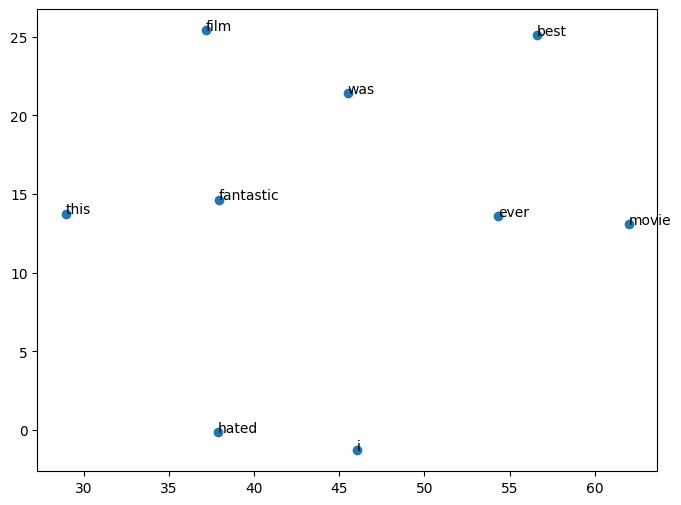

In [39]:
#[Problem 7] (Advance assignment) Vector Visualization

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]   # matriz (vocab_size x embedding_dim)

word_index = tokenizer.word_index
reverse_word_index = {v: k for k, v in word_index.items()}

words = list(word_index.keys())
X = weights[1:len(words)+1]   # índice 0 é padding

tsne = TSNE(n_components=2, random_state=42, perplexity=5)
X_2d = tsne.fit_transform(X)

plt.figure(figsize=(8,6))
plt.scatter(X_2d[:,0], X_2d[:,1])
for i, word in enumerate(words):
    plt.annotate(word, (X_2d[i,0], X_2d[i,1]))
plt.show()


In [42]:
#[Issue 8] (Advance assignment) Classification of movie reviews using Word2Vec

from sklearn.linear_model import LogisticRegression

embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]  # shape: vocab_size x embedding_dim

word_index = tokenizer.word_index
index_to_word = {v:k for k,v in word_index.items()}

def doc_vector(tokens):
    vectors = []
    for w in tokens:
        idx = word_index.get(w)
        if idx is not None: 
            vectors.append(weights[idx])
    if len(vectors) == 0:
        return np.zeros(weights.shape[1])
    return np.mean(vectors, axis=0)

corpus_tokens = [["this","movie","was","fantastic"],
                 ["i","hated","this","film"],
                 ["best","ever"]]

X = np.array([doc_vector(doc) for doc in corpus_tokens])
y = [1, 0, 1]  # exemplo de labels

clf = LogisticRegression(max_iter=200)
clf.fit(X, y)

print("Predictions:", clf.predict(X))


Predictions: [1 1 1]
